Consider now a network of links. For simplicity, suppose that the network is a complete graph on $K$ nodes, i.e., there is a link between every pair of nodes $\{1, \dots, K\}$, and that each link has capacity $C$. Suppose that for every pair of nodes $(a, b)$, calls between $a$ and $b$ arise as a Poisson process of rate $\nu$. It might seem reasonable, in order to reduce the blocking probability, to offer an alternative route if the direct link is full. Specifically, suppose that calls between $a$ and $b$ are routed as follows:

1.  If there is spare capacity on the direct link $a \leftrightarrow b$, then route the call over that link.
2.  Otherwise, pick a new node $c$ uniformly at random from the other $K - 2$ nodes. If there is spare capacity on $a \leftrightarrow c$ and on $c \leftrightarrow b$, then route the call over these two links.
3.  Otherwise, the call is blocked.

We will call this the alternative routing system. It is possible in principle to set up a Markov process model for this system but the number of states is so large that it is not computationally practical to do so. Instead, we can use the Erlang fixed point approximation, which is that blocking occurs independently on different links. This leads to the fixed point formula
\begin{equation}
    B = E(\nu + 2\nu B(1 − B), C)
\end{equation}
where $B$ is the probability that an incoming call cannot be routed on its chosen direct link.

The intuition of the formula lies inside the Erlang function $E(\cdot, C)$. The first argument represents the total traffic load $\lambda$ that is offered to a link with capacity $C$ which is a combination of two distinct types of traffic:

1.  Primary Traffic: Calls that are intended for that specific link as their first choice. This is represented by $\nu$ which is the rate of the Poisson process between any pair of nodes.
2.  Overflow Traffic: Calls that were intended for a different direct link and are being rerouted. This is represented by $2\nu B(1 - B)$.
    *   The factor $\nu B$ is the rate of overflow generation, which comes from the probability that any given link is full $B$ and the arrival rate $\nu$.
    *   The rate of overflow traffic directed at a specific link $x \leftrightarrow y$ is $2\nu B$. Since $x \leftrightarrow z$ is busy, the system randomly picks $y$ as the intermediate node.

By summing up all possibilities (with symmetry), the total rate at which overflow calls are directed towards $x \leftrightarrow y$ is $2\nu B$. This represents the stream of rerouted calls that will attempt to use our link.

However, this is not purely random as overflows tend to happen in bursts when the network is generally congested. The Erlang formula, however, assumes the incoming traffic is Poisson. An overflowing call will attempt to create a two-link path via an intermediate node. The model approximates the load offered to the first link by considering only the overflow attempts that have a chance of succeeding. Under the assumption that link blockings are independent, the probability that the second link is available is $(1 - B)$.

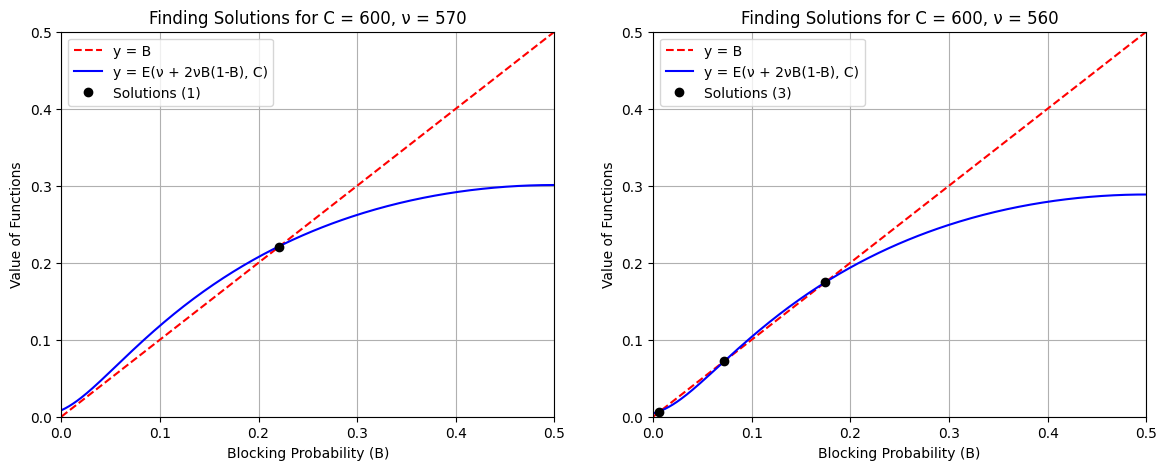

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import math
from scipy.special import gammaln, logsumexp


def erlang_b_formula(nu, C):
    '''
    Calculates the theoretical blocking probability using the Erlang B formula.
    Using log-sum-exp trick to avoid numerical overflow for large nu and C.
    '''
    if C < 0 or not isinstance(C, int):
        raise ValueError("Capacity (C) must be a non-negative integer.")
    if nu < 0:
        # Physically meaningless for offered load, treat as no load.
        return 0.0

    # Special case for C=0
    if C == 0:
        return 1.0 if nu > 0 else 0.0

    # Special case for nu=0
    if nu == 0:
        return 0.0

    # Calculate log of terms: log(nu^k / k!) = k * log(nu) - gammaln(k + 1)
    log_terms = [
        k * np.log(nu) - gammaln(k + 1) for k in range(C + 1)
    ]

    # The numerator for Erlang B is (nu^C / C!)
    log_numerator = C * np.log(nu) - gammaln(C + 1)

    # The denominator is sum_{k=0 to C} (nu^k / k!) which we compute using logsumexp
    log_denominator = logsumexp(log_terms)

    # If log_denominator is -inf, it means all terms were effectively zero.
    # This should not happen for nu > 0 and C >= 0 when calculated correctly.
    if log_denominator == -np.inf:
        return 0.0

    log_blocking_probability = log_numerator - log_denominator
    blocking_probability = np.exp(log_blocking_probability)

    return blocking_probability

def plot_fixed_point_solutions(C, nu, ax):
    '''
    Plots the two sides of the Erlang fixed-point equation to find solutions.
    '''
    # B is a probability, so it ranges from 0 to 1
    B_values = np.linspace(0, 1, 500)
    y1 = B_values
    offered_load = nu + 2 * nu * B_values * (1 - B_values)
    y2 = [erlang_b_formula(load, C) for load in offered_load]

    ax.plot(B_values, y1, 'r--', label='y = B')
    ax.plot(B_values, y2, 'b-', label='y = E(ν + 2νB(1-B), C)')

    # Find intersections (solutions) by checking where the difference changes sign
    diff = np.array(y2) - y1
    intersections = np.where(np.diff(np.sign(diff)))[0]

    ax.plot(B_values[intersections], y1[intersections], 'ko', label=f'Solutions ({len(intersections)})')

    ax.set_title(f'Finding Solutions for C = {C}, ν = {nu}')
    ax.set_xlabel('Blocking Probability (B)')
    ax.set_ylabel('Value of Functions')
    ax.legend()
    ax.grid(True)
    ax.set_xlim(0, 0.5)
    ax.set_ylim(0, 0.5)

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

C1 = 600
nu1 = 570
plot_fixed_point_solutions(C1, nu1, axes[0])

C2 = 600
nu2 = 560
plot_fixed_point_solutions(C2, nu2, axes[1])

plt.show()

In a stable, low-congestion state, the primary traffic $\nu$ is well below the capacity $C$, so there is very little overflow traffic generated. The system easily handles the load, resulting in a singlelow blocking probability.

On the other hand, for a stable high-congestion state, the primary traffic $\nu$ is too high for the capacity $C$ to handle, so almost every call is overflowed and blcked. The system behaves similarly to one without alternative routing and there is a single high blocking probability.

There is also a critical region which demonstrates multiple stable states for the network. We see three fixed points:
*   Low-blocking solution: This is the desirable, efficient operating state. If the network starts with low traffic, then it can remain in this state.
*   High-blocking solution: This is the congested state. The high blocking probability $B$ generates a large amount of overflow traffic $2\nu B(1-B)$, which causes a positive feedback loop.
*   Unstable solution: Any small fluctuation in traffic will push the system towards either the low-blocking or the high-blocking state.